In [0]:
#https://medium.com/towards-artificial-intelligence/application-of-synthetic-minority-over-sampling-technique-smote-for-imbalanced-data-sets-509ab55cfdaf
#This Code predict Assignee for Roslyn Issues with Title

import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.utils.vis_utils import plot_model
from sklearn import preprocessing
from IPython.display import SVG
from keras.utils import model_to_dot
from imblearn.over_sampling import SMOTE
from bs4 import BeautifulSoup
from math import sqrt


url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(url)

data = pd.read_csv('IssueDetailsRoslyn_20102019_Single.csv', encoding='latin-1')
data = data.reindex(np.random.permutation(data.index))
y = list(data['Assignee']) 
x = list(data['Title']) 

le = preprocessing.LabelEncoder()
le.fit(y)

categories = list(set(y))

def encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

test = encode(le,categories)

untest = decode(le, test)

x_enc = x
y_enc = encode(le, y)

#80% / 20% train / test split:

train_size = int(len(x) * .8)

#x_train = np.asarray(x_enc[:train_size])
x_train = data['Title'].tolist()
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  x_train = session.run(embed(x_train))
#x_train = np.array(x_train[:train_size], dtype=object)[:, np.newaxis]
x_train = np.array(x_train[:train_size], dtype=object)
y_train = np.asarray(y_enc[:train_size])

x_test = np.asarray(x_enc[train_size:])
y_test = np.asarray(y_enc[train_size:])

In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
# X_f and y_f are the Training Set Features and Labels respectively 
X_res, y_res = ros.fit_resample(x_train, y_train)

In [197]:
y_res.shape[1]

44

In [0]:
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

def UniversalEmbedding(x):
    return embed(tf.squeeze(x))

In [208]:
x_train_SMOTE.shape

(1430, 512)

In [209]:
import tensorflow as tf
input_text = Input(shape=(512,))
#embedding = Lambda(UniversalEmbedding, output_shape=(512,))(input_text)
#Add the dense layer with 256 units and recified learn 
dense = Dense(256, activation='relu', input_shape=(512,))(input_text)
#Add the dense with No of Categories unit and softmax function
pred = Dense(y_res.shape[1], activation='softmax')(dense)
model = Model(inputs=[input_text], outputs=pred)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_44 (Dense)             (None, 46)                11822     
Total params: 143,150
Trainable params: 143,150
Non-trainable params: 0
_________________________________________________________________


In [210]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model.fit(X_res, y_res, epochs=100, batch_size=32)
    model.save_weights('./model_roslyn_Title_Assignee_Prediction.h5')

Epoch 1/100
5888/5888 [==============================] - 16s 3ms/step - loss: 2.5353 - acc: 0.5099
Epoch 2/100
5888/5888 [==============================] - 1s 175us/step - loss: 1.2361 - acc: 0.7040
Epoch 3/100
5888/5888 [==============================] - 1s 169us/step - loss: 0.9386 - acc: 0.7655
Epoch 4/100
5888/5888 [==============================] - 1s 169us/step - loss: 0.7723 - acc: 0.8072
Epoch 5/100
5888/5888 [==============================] - 1s 182us/step - loss: 0.6559 - acc: 0.8346
Epoch 6/100
5888/5888 [==============================] - 1s 177us/step - loss: 0.5685 - acc: 0.8567
Epoch 7/100
5888/5888 [==============================] - 1s 174us/step - loss: 0.4969 - acc: 0.8758
Epoch 8/100
5888/5888 [==============================] - 1s 177us/step - loss: 0.4354 - acc: 0.8939
Epoch 9/100
5888/5888 [==============================] - 1s 168us/step - loss: 0.3865 - acc: 0.9108
Epoch 10/100
5888/5888 [==============================] - 1s 179us/step - loss: 0.3467 - acc: 0.9226


In [211]:
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  x_test = session.run(embed(x_test))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    model.load_weights('./model_roslyn_Title_Assignee_Prediction.h5')  
    predicts = model.predict(x_train, batch_size=32)  

In [214]:
y_test = np.asarray(y_enc[:train_size])


y_test = decode(le, y_test)
y_preds = decode(le, predicts)

from sklearn import metrics

metrics.confusion_matrix(y_test, y_preds)

print(metrics.classification_report(y_test, y_preds))


                     precision    recall  f1-score   support

            333fred       1.00      1.00      1.00        15
            AArnott       1.00      1.00      1.00         1
    AdamSpeight2008       1.00      1.00      1.00         1
          AlekseyTs       1.00      1.00      1.00        10
           AmadeusW       1.00      1.00      1.00         2
         BillWagner       1.00      1.00      1.00         1
            Cosifne       1.00      1.00      1.00         1
     CyrusNajmabadi       1.00      1.00      1.00         5
          JoeRobich       1.00      0.95      0.97        20
        RikkiGibson       1.00      0.97      0.98        30
              TIHan       0.00      0.00      0.00         0
              abock       0.00      0.00      0.00         1
             agocke       0.00      0.00      0.00        19
        allisonchou       0.00      0.00      0.00         8
               alrz       0.00      0.00      0.00         1
            canton7    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Number of descriptions: 895 
Average word count 90.37430167597765 
Minimum word count 1 
Maximum word count 1220


KeyError: ignored

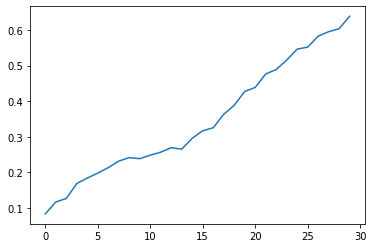

In [26]:
#statistics
data['word_count'] = data['Description'].apply(lambda x: len(str(x).split()))
desc_lengths = list(data['word_count'])
print("Number of descriptions:",len(desc_lengths),
      "\nAverage word count", np.average(desc_lengths),
      "\nMinimum word count", min(desc_lengths),
      "\nMaximum word count", max(desc_lengths))

#Model Graph
plot_model(model, to_file='model_roslyn_Title_Assignee_Prediction_plot.png', expand_nested=True, show_shapes=True, show_layer_names=True)

#SVG Diagram
#SVG(model_to_dot(model).create(prog='dot', format='svg'))



# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# New Section